<a href="https://colab.research.google.com/github/AnantChandra/google-colab/blob/main/gcn_karate_club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

In [2]:
!pip install optuna
!pip install --upgrade matplotlib

In [3]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch.nn import Linear

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [4]:
dataset = KarateClub()
data = dataset[0]

In [5]:
print(dataset.num_features)

34


In [6]:
import pandas as pd

In [7]:
node_features_df = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])

In [8]:
node_features_df['node'] = node_features_df.index

In [9]:
node_features_df.set_index('node', inplace=True)

In [13]:
edge_index_df = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])

In [14]:
labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])

In [16]:
labels_df['node'] = labels_df.index

In [17]:
labels_df.set_index('node', inplace=True)

In [18]:
num_nodes = data.num_nodes

In [19]:
num_edges = data.num_edges

In [20]:
print(edge_index_df.head())

   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [21]:
num_countries = 4
np.random.seed(42)
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))
data.y = countries

In [22]:
G = to_networkx(data, to_undirected=True)

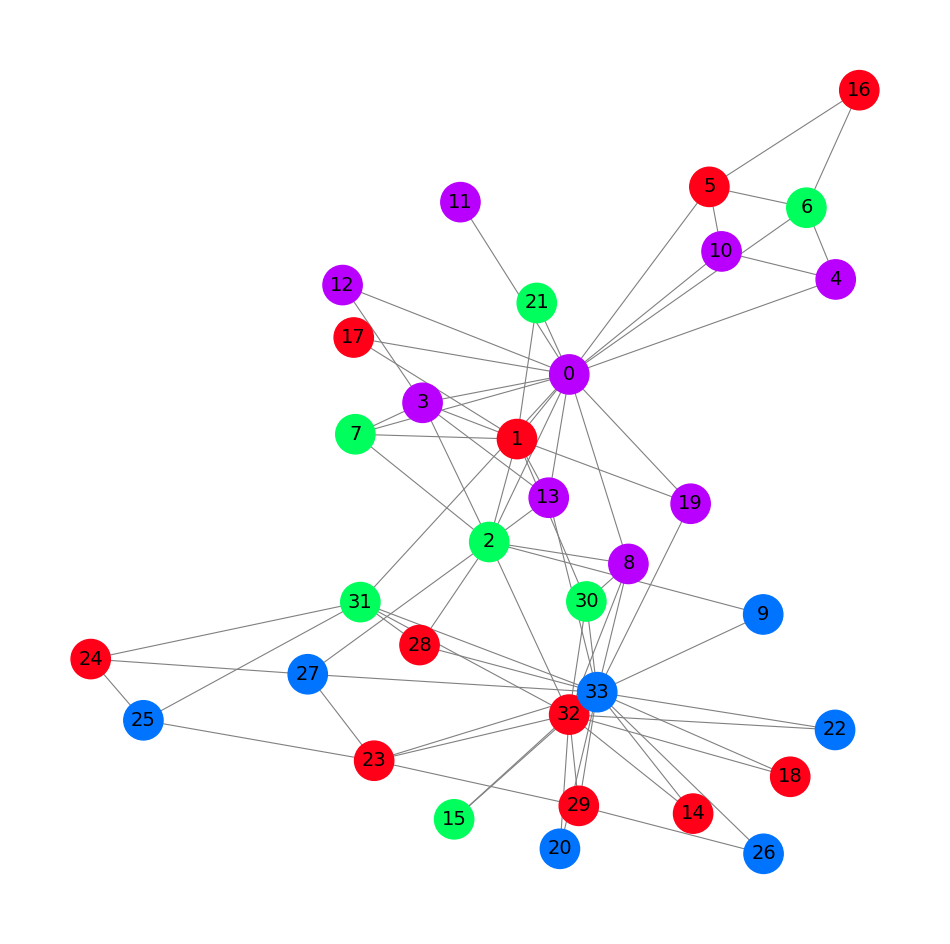

In [23]:
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 with_labels=True,
                 node_size=800,
                 node_color=data.y,
                 cmap="hsv",
                 vmin=-2,
                 vmax=3,
                 width=0.8,
                 edge_color="grey",
                 font_size=14
                 )
plt.show()

In [24]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, num_countries)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

In [25]:
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [27]:
criterion = torch.nn.CrossEntropyLoss()

In [28]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [29]:
embeddings = []
accuracies = []
losses = []
outputs = []

In [30]:
for epoch in range(200):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.41 | Acc: 20.59%
Epoch  10 | Loss: 1.31 | Acc: 52.94%
Epoch  20 | Loss: 1.20 | Acc: 55.88%
Epoch  30 | Loss: 1.05 | Acc: 58.82%
Epoch  40 | Loss: 0.85 | Acc: 61.76%
Epoch  50 | Loss: 0.68 | Acc: 79.41%
Epoch  60 | Loss: 0.53 | Acc: 85.29%
Epoch  70 | Loss: 0.42 | Acc: 88.24%
Epoch  80 | Loss: 0.33 | Acc: 91.18%
Epoch  90 | Loss: 0.25 | Acc: 100.00%
Epoch 100 | Loss: 0.20 | Acc: 100.00%
Epoch 110 | Loss: 0.15 | Acc: 100.00%
Epoch 120 | Loss: 0.12 | Acc: 100.00%
Epoch 130 | Loss: 0.09 | Acc: 100.00%
Epoch 140 | Loss: 0.08 | Acc: 100.00%
Epoch 150 | Loss: 0.06 | Acc: 100.00%
Epoch 160 | Loss: 0.05 | Acc: 100.00%
Epoch 170 | Loss: 0.05 | Acc: 100.00%
Epoch 180 | Loss: 0.04 | Acc: 100.00%
Epoch 190 | Loss: 0.04 | Acc: 100.00%


In [31]:
print(h.shape)
print(h)

torch.Size([34, 3])
tensor([[1.8890e+00, 1.9959e-01, 9.6103e-01],
        [1.0595e+00, 1.5923e+00, 1.5864e+00],
        [1.5234e+00, 1.3227e+00, 6.6834e-02],
        [2.2703e+00, 3.6543e-01, 8.8612e-01],
        [1.9460e+00, 0.0000e+00, 4.3487e-01],
        [6.1426e-01, 1.5165e+00, 1.0100e+00],
        [1.2612e+00, 1.4821e+00, 1.3564e-01],
        [1.6835e+00, 1.7019e+00, 1.6184e-01],
        [1.7889e+00, 5.4132e-01, 8.3790e-01],
        [7.7745e-01, 0.0000e+00, 2.2909e+00],
        [1.8921e+00, 4.6122e-04, 5.5514e-01],
        [2.3933e+00, 0.0000e+00, 7.0636e-01],
        [2.5454e+00, 0.0000e+00, 8.6880e-01],
        [2.0377e+00, 3.0398e-01, 1.1636e+00],
        [6.0682e-01, 1.9685e+00, 1.5374e+00],
        [1.9266e+00, 2.0434e+00, 2.4159e-01],
        [2.0176e-01, 2.4996e+00, 9.3168e-01],
        [7.7719e-01, 2.1628e+00, 1.3450e+00],
        [6.0737e-01, 1.9117e+00, 1.5187e+00],
        [2.0723e+00, 1.2106e-01, 1.2306e+00],
        [6.4092e-01, 2.8572e-01, 1.7159e+00],
        [1.410

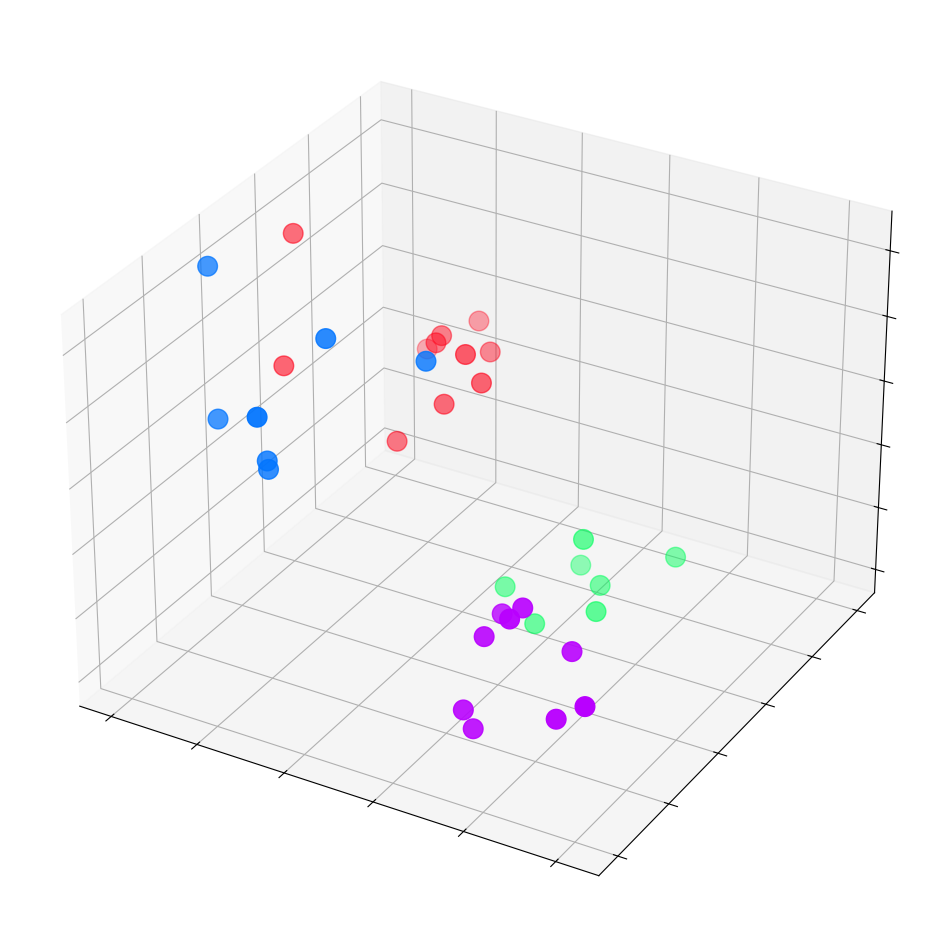

In [32]:
embed = h.detach().cpu().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

In [33]:
def animate_3d(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch: {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%', fontsize=18)

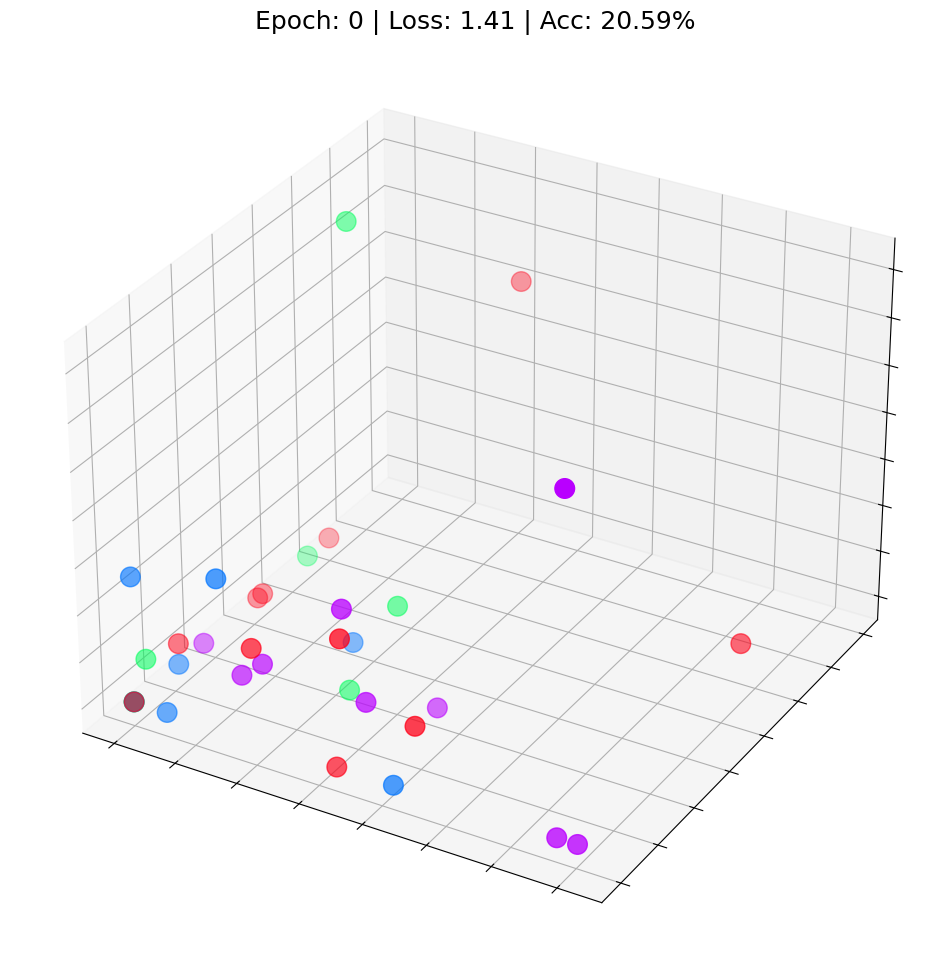

In [34]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
anim = animation.FuncAnimation(fig, animate_3d, np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)